# Experiment 1 analyses

In [ ]:
import os 
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

experiment_name = '254a_class_pilot'
iteration_name = 'pilot_local_2'

project_dir = os.path.abspath('../../')
data_dir = os.path.join(project_dir, 'data')
model_dir = os.path.join(data_dir, 'models')
behavior_dir = os.path.join(data_dir, 'behavioral_results', experiment_name, iteration_name)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
model_df = pd.read_csv(os.path.join(model_dir, 'model_results.csv'))
session_df = pd.read_csv(os.path.join(behavior_dir, 'session_data.csv'))
trial_df = pd.read_csv(os.path.join(behavior_dir, 'trial_data.csv'))

model_df['congruent_full'] = model_df.apply(lambda x: (
    (x.intended_recipe == x.model_recipe) or ('either' in x.intended_recipe)) and \
    ((x.intended_num_agents == x.model_num_agents) or ('either' in x.intended_num_agents))
                            , axis=1)
model_df['congruent_full'] = model_df.congruent_full.apply(lambda x: 'congruent' if x else 'incongruent')

### Experiment descriptive analysis

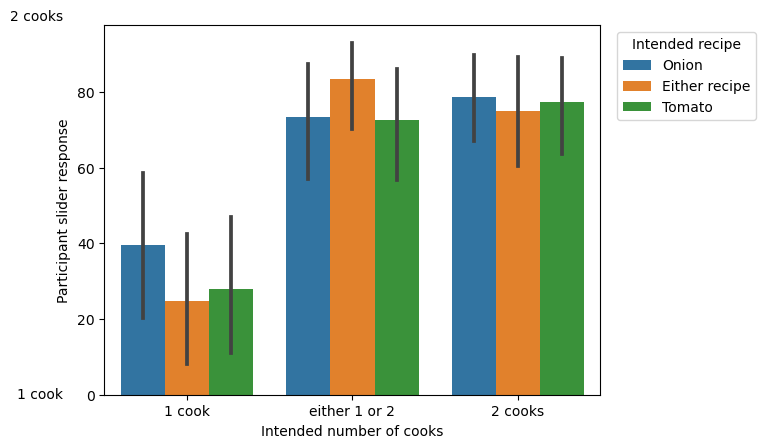

In [3]:
cooks_order = ['1agent', 'either_agents', '2agent']
dish_order = ['onion', 'either_recipe', 'tomato']
cook_map = {'1agent': '1 cook', 'either_agents': 'either 1 or 2', '2agent': '2 cooks'}
dish_map = {'onion': 'Onion', 'either_recipe': 'Either recipe', 'tomato': 'Tomato'}

ax = sns.barplot(
    data=trial_df, 
    x='true_num_agents', 
    y='slider_num_agents', 
    hue='true_recipe',
    order=cooks_order,
    hue_order=dish_order,
    errorbar='ci'
)

ax.set_ylabel("Participant slider response")
ax.set_xlabel("Intended number of cooks")
ax.set_xticklabels([cook_map[t.get_text()] for t in ax.get_xticklabels()])
ax.text(x=-0.75, y=0, s="1 cook", va="center", ha="right", fontsize=10)
ax.text(x=-0.75, y=100, s="2 cooks", va="center", ha="right", fontsize=10)

handles, labels = ax.get_legend_handles_labels()  
new_labels = [dish_map.get(lbl, lbl) for lbl in labels]  
ax.legend(
    handles=handles, 
    labels=new_labels,
    title="Intended recipe",
    loc='upper left',
    bbox_to_anchor=(1.02, 1.00)
)
plt.show()

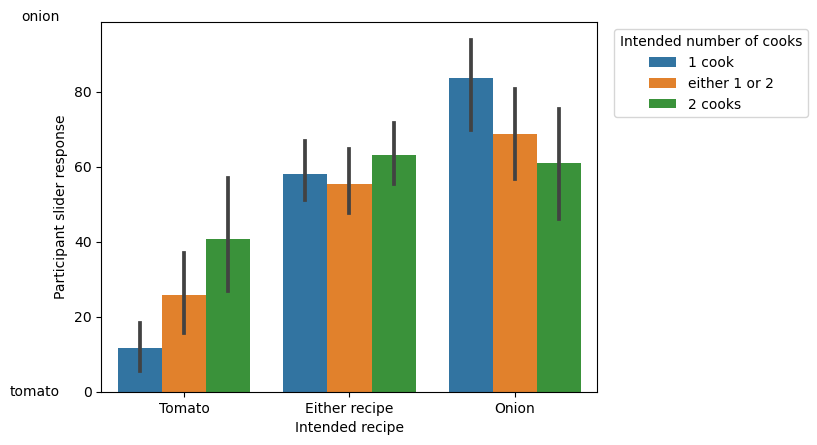

In [4]:
cooks_order = ['1agent', 'either_agents', '2agent']
dish_order = ['tomato', 'either_recipe', 'onion']
cook_map = {'1agent': '1 cook', 'either_agents': 'either 1 or 2', '2agent': '2 cooks'}
dish_map = {'onion': 'Onion', 'either_recipe': 'Either recipe', 'tomato': 'Tomato'}

ax = sns.barplot(
    data=trial_df, 
    x='true_recipe', 
    y='slider_recipe', 
    hue='true_num_agents',
    order=dish_order,
    hue_order=cooks_order,
    errorbar='ci'
)

ax.set_ylabel("Participant slider response")
ax.set_xlabel("Intended recipe")
ax.set_xticklabels([dish_map[t.get_text()] for t in ax.get_xticklabels()])
ax.text(x=-0.75, y=0, s="tomato", va="center", ha="right", fontsize=10)
ax.text(x=-0.75, y=100, s="onion", va="center", ha="right", fontsize=10)

handles, labels = ax.get_legend_handles_labels()  
new_labels = [cook_map.get(lbl, lbl) for lbl in labels]  
ax.legend(
    handles=handles, 
    labels=new_labels,
    title="Intended number of cooks",
    loc='upper left',
    bbox_to_anchor=(1.02, 1.00)
)
plt.show()

### Model descriptive analysis

In [9]:
model_slider_preds = []
for intention, group in model_df.groupby('intention'):
    recipe_agg = group.groupby('model_recipe').timesteps.mean()
    agents_agg = group.groupby('model_num_agents').timesteps.mean()
    model_agg  = group.groupby('model_run').timesteps.mean()
    model_agg.index = [f'model-{key}-timesteps' for key in model_agg.index]
    
    model_slider_preds.append({
        'intended_recipe': group.intended_recipe.iloc[0],
        'intended_num_agents': group.intended_num_agents.iloc[0],
        'model_recipe_slider_pred': recipe_agg['tomato'] / sum(recipe_agg) * 100,
        'model_agents_slider_pred': agents_agg['1agent'] / sum(agents_agg) * 100,
        'model_recipe_judgment': recipe_agg['onion'] < recipe_agg['tomato'], 
        'model_agents_judgment': agents_agg['2agent'] < agents_agg['1agent'],  
        **model_agg
    })
    
model_slider_preds = pd.DataFrame(model_slider_preds)
model_slider_preds["intended_recipe"] = pd.Categorical(
    model_slider_preds["intended_recipe"],
    categories=dish_order,
    ordered=True
)
model_slider_preds["intended_num_agents"] = pd.Categorical(
    model_slider_preds["intended_num_agents"],
    categories=cooks_order,
    ordered=True
)

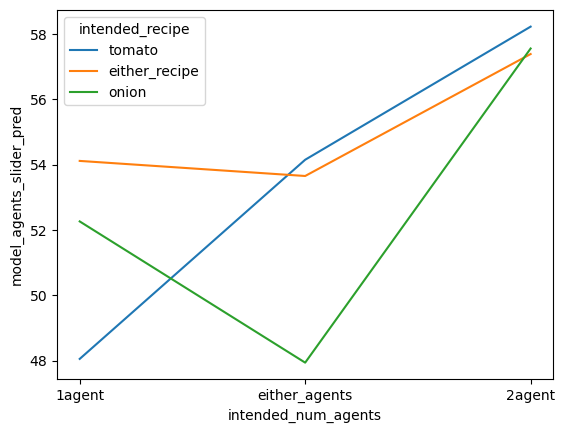

In [10]:
ax = sns.lineplot(
    data=model_slider_preds, 
    x='intended_num_agents', 
    y='model_agents_slider_pred', 
    hue='intended_recipe',
    errorbar='ci',
#     order=cooks_order,
#     hue_order=dish_order,
)
# ax.set_ylim(0, 100)


In [11]:
trial_df['model_recipe_slider_pred'] = trial_df.set_index(
    ['true_recipe', 'true_num_agents']).index.map(
    model_slider_preds.set_index(['intended_recipe', 'intended_num_agents']).model_recipe_slider_pred)
trial_df['model_agents_slider_pred'] = trial_df.set_index(
    ['true_recipe', 'true_num_agents']).index.map(
    model_slider_preds.set_index(['intended_recipe', 'intended_num_agents']).model_agents_slider_pred)

trial_df['model_recipe_judgment'] = trial_df.set_index(
    ['true_recipe', 'true_num_agents']).index.map(
    model_slider_preds.set_index(['intended_recipe', 'intended_num_agents']).model_recipe_judgment)
trial_df['model_agents_judgment'] = trial_df.set_index(
    ['true_recipe', 'true_num_agents']).index.map(
    model_slider_preds.set_index(['intended_recipe', 'intended_num_agents']).model_agents_judgment)

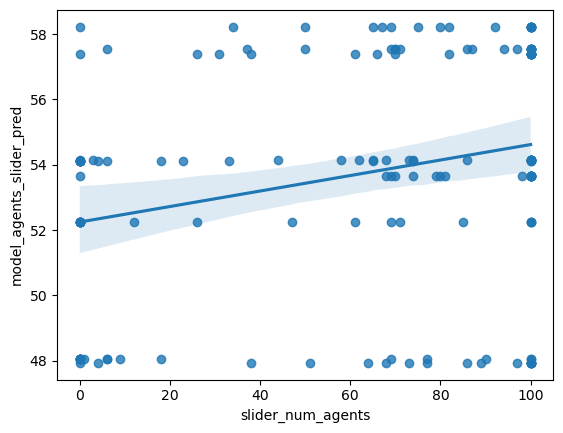

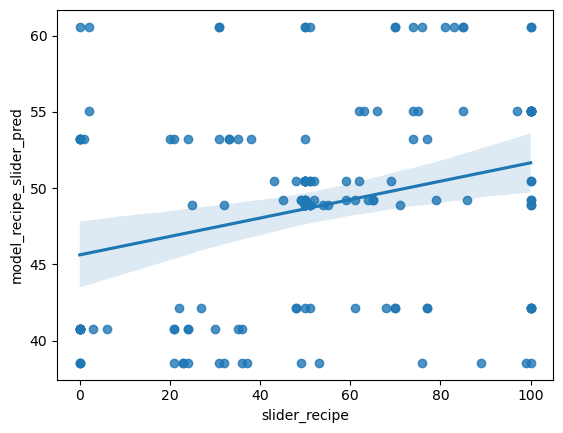

                          slider_num_agents  model_agents_slider_pred
slider_num_agents                  1.000000                  0.258679
model_agents_slider_pred           0.258679                  1.000000
                          slider_recipe  model_recipe_slider_pred
slider_recipe                  1.000000                  0.277936
model_recipe_slider_pred       0.277936                  1.000000


In [12]:
sns.regplot(data=trial_df, x='slider_num_agents', y='model_agents_slider_pred')
plt.show()
sns.regplot(data=trial_df, x='slider_recipe', y='model_recipe_slider_pred')
plt.show()
print(trial_df[['slider_num_agents', 'model_agents_slider_pred']].corr())
print(trial_df[['slider_recipe', 'model_recipe_slider_pred']].corr())

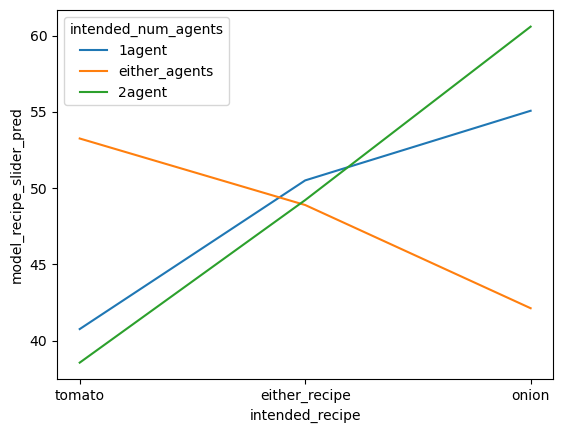

In [13]:
ax = sns.lineplot(
    data=model_slider_preds, 
    x='intended_recipe', 
    y='model_recipe_slider_pred', 
    hue='intended_num_agents',
    errorbar='ci',
#     order=dish_order,
#     hue_order=cooks_order,
)
# ax.set_ylim(0, 100)


In [14]:
model_df.head()

,intended_num_agents,intended_recipe,intention,model_num_agents,model_recipe,model_run,design_congruent,seed,timesteps,agent_pauses,agent_collisions,was_successful,congruent_full
0,1agent,onion,1agent-onion,1agent,onion,1agent-onion,congruent,1,30,0,0,True,congruent
1,1agent,onion,1agent-onion,1agent,onion,1agent-onion,congruent,2,28,0,0,True,congruent
2,1agent,onion,1agent-onion,1agent,onion,1agent-onion,congruent,3,30,0,0,True,congruent
3,1agent,onion,1agent-onion,1agent,onion,1agent-onion,congruent,4,30,0,0,True,congruent
4,1agent,onion,1agent-onion,1agent,onion,1agent-onion,congruent,5,30,0,0,True,congruent


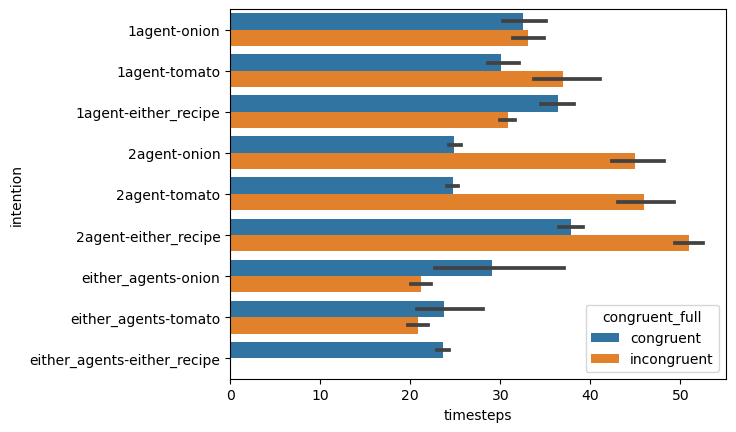

In [15]:
# MANIPULATION CHECK
sns.barplot(data=model_df,
            x='timesteps', 
            y='intention', 
            hue='congruent_full',
            errorbar='ci')
plt.show()

In [16]:
print(model_df.groupby(['intended_num_agents', 'intended_recipe', 'model_num_agents', 'model_recipe']).timesteps.mean(), '\n')

print(model_df.groupby(['intended_num_agents', 'model_num_agents']).timesteps.mean(), '\n')

print(model_df.groupby(['intended_recipe', 'model_recipe']).timesteps.mean(), '\n')

print(model_df.groupby(['model_num_agents', 'model_recipe']).timesteps.mean(), '\n')

print(model_df.groupby(['intended_num_agents', 'intended_recipe']).timesteps.mean())

intended_num_agents  intended_recipe  model_num_agents  model_recipe
1agent               either_recipe    1agent            onion           35.40
                                                        tomato          37.30
                                      2agent            onion           31.10
                                                        tomato          30.55
                     onion            1agent            onion           32.50
                                                        tomato          36.30
                                      2agent            onion           26.65
                                                        tomato          36.20
                     tomato           1agent            onion           37.70
                                                        tomato          30.10
                                      2agent            onion           45.90
                                                        tomato          2

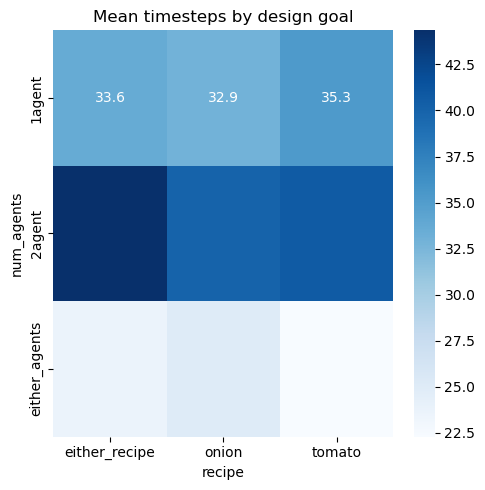

In [17]:
mean_table = model_df.pivot_table(
    index="intended_num_agents",
    columns="intended_recipe",
    values="timesteps",
    aggfunc="mean"
)

plt.figure(figsize=(5, 5))
sns.heatmap(mean_table, annot=True, fmt=".1f", cmap="Blues")
plt.title("Mean timesteps by design goal")
plt.ylabel("num_agents")
plt.xlabel("recipe")
plt.tight_layout()
plt.show()


### Model comparison

In [ ]:
df_full = ...